### Twitter API Request Code
```
# Authentication
consumerKey = creds['API Key']
consumerSecret = creds['API Key Secret']
accessToken = creds['Access Token']
accessTokenSecret = creds['Access Token Secret']
auth = tweepy.OAuthHandler(consumerKey, consumerSecret)
auth.set_access_token(accessToken, accessTokenSecret)
api = tweepy.API(auth)

#Sentiment Analysis
def percentage(part,whole):
 return 100 * float(part)/float(whole)
keyword = input('Please enter keyword or hastag to search: ')
noOfTweet = int(input ('Please enter how many tweets to analyze: '))
tweets = tweepy.Cursor(api.search_tweets, q=keyword+' -filter:retweets').items(noOfTweet)
positive = 0
negative = 0
neutral = 0
polarity = 0
tweet_list = []
tweet_date_list = []
neutral_list = []
negative_list = []
positive_list = []
for tweet in tweets:
 
 #print(tweet.text)
    tweet_list.append(tweet.text)
    tweet_date_list.append(tweet.created_at)
    analysis = TextBlob(tweet.text)
    score = SentimentIntensityAnalyzer().polarity_scores(tweet.text)
    neg = score['neg']
    neu = score['neu']
    pos = score['pos']
    comp = score['compound']
    polarity += analysis.sentiment.polarity

    if neg > pos:
        negative_list.append(tweet.text)
        negative += 1
    elif pos > neg:
        positive_list.append(tweet.text)
        positive += 1
    elif pos == neg:
        neutral_list.append(tweet.text)
        neutral += 1

positive = percentage(positive, noOfTweet)
negative = percentage(negative, noOfTweet)
neutral = percentage(neutral, noOfTweet)
polarity = percentage(polarity, noOfTweet)
positive = format(positive, '.1f')
negative = format(negative, '.1f')
neutral = format(neutral, '.1f')

#Number of Tweets (Total, Positive, Negative, Neutral)
tweet_list = pd.DataFrame(tweet_list)
neutral_list = pd.DataFrame(neutral_list)
negative_list = pd.DataFrame(negative_list)
positive_list = pd.DataFrame(positive_list)
print('total number: ',len(tweet_list))
print('positive number: ',len(positive_list))
print('negative number: ', len(negative_list))
print('neutral number: ',len(neutral_list))
```

In [6]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

# Import Libraries
from textblob import TextBlob
import sys
import tweepy
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import nltk
import pycountry
import re
import string
import json

# from wordcloud import WordCloud, STOPWORDS
from PIL import Image
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment import SentimentAnalyzer
from langdetect import detect
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score

In [7]:
with open('/Users/evanjays/.secrets/twitter_creds.json') as f:
    creds = json.load(f)

df_2013 = pd.read_csv('data/judge-1377884607_tweet_product_company.csv', encoding = "ISO-8859-1")
df_2013.drop(6,inplace=True)

df_1 = pd.DataFrame(pd.read_csv('data/doge_tweets_111621_1138',index_col=0)['text'])
df_2 = pd.DataFrame(pd.read_csv('data/dogecoin2_11_16_21_1pm.csv',index_col=0)['text'])
df=pd.concat([df_1,df_2])
df.drop_duplicates(inplace=True)
df

,text
0,@binance @BinanceChain @dogecoin
1,@DogecoinNorway @occupymars42069 @dogeofficial...
2,"16 November 2021, 07:36h \n\nThe current price..."
3,Give some tip today to a friend or family memb...
4,@Jayecane Help everyone by getting them into #...
...,...
2495,#linkedin #twitter #facebook #instagram #dogec...
2496,"@mario_snajder @shibworld My friend, there is ..."
2497,"@airdropcryt_ico @shibworld My friend, there i..."
2498,"@jisungie_02 @shibworld My friend, there is a ..."


In [8]:
def get_top_n_gram(corpus,ngram_range,n=None):
    vec = TfidfVectorizer(ngram_range=ngram_range,stop_words = 'english',max_df=1.0, min_df=0.0).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n], bag_of_words

In [9]:
remove_rt = lambda x: re.sub('RT @\w+: '," ",x)
rt = lambda x: re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+://\S+)"," ",x)
df["clean_text"] = df.text.map(remove_rt).map(rt)
df["clean_text"] = df.clean_text.str.lower()

top_list,vec = get_top_n_gram(df['clean_text'], (2,3),500)

#Calculating Negative, Positive, Neutral and Compound values
df_probs = pd.DataFrame()
df_probs[['polarity', 'subjectivity']] = df['clean_text'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))
for index, row in df['text'].iteritems():
    score = SentimentIntensityAnalyzer().polarity_scores(row)
    neg = score['neg']
    neu = score['neu']
    pos = score['pos']
    comp = score['compound']
    if neg > pos:
        df_probs.loc[index, 'sentiment'] = 0
    elif pos > neg:
        df_probs.loc[index, 'sentiment'] = 1
    else:
        df_probs.loc[index, 'sentiment'] = 0
    df_probs.loc[index, 'neg'] = neg
    df_probs.loc[index, 'neu'] = neu
    df_probs.loc[index, 'pos'] = pos
    df_probs.loc[index, 'compound'] = comp
df_probs.head(10)

,polarity,subjectivity,sentiment,neg,neu,pos,compound
0,0.000000,0.000000,0.0,0.0,1.000,0.000,0.0000
1,0.000000,0.000000,0.0,0.0,1.000,0.000,0.0000
2,0.000000,0.350000,1.0,0.0,0.833,0.167,0.5859
3,0.000000,0.000000,1.0,0.0,0.674,0.326,0.5255
4,0.000000,0.000000,0.0,0.0,1.000,0.000,0.0000
5,0.000000,0.000000,0.0,0.0,1.000,0.000,0.0000
6,0.309028,0.729167,0.0,0.0,1.000,0.000,0.0000
7,0.445455,0.351515,0.0,0.0,1.000,0.000,0.0000
8,-0.400000,0.400000,0.0,0.0,1.000,0.000,0.0000
9,0.000000,0.000000,0.0,0.0,1.000,0.000,0.0000


In [10]:
X_train,X_test,y_train,y_test = train_test_split(vec.todense(),df_probs['sentiment'],random_state=1)

# kmeans = KMeans(n_clusters=3)
nb = MultinomialNB()
# dt = DecisionTreeClassifier()

pca = PCA(n_components=1)

pca_vec = pca.fit_transform(vec.todense())

df_pc = pd.DataFrame(pca_vec,columns=['PC_1'])
df_pc.reset_index(inplace=True,drop=True)
df_compound = pd.DataFrame(df_probs.compound)
df_compound.reset_index(inplace=True,drop=True)

X = pd.concat([df_pc,df_compound],axis=1,ignore_index=True)

ss = StandardScaler()
X_scaled = ss.fit_transform(X)

# kmeans.fit(X_scaled)
nb.fit(X_train,y_train)
# dt.fit(X_train,y_train)

# y_preds = kmeans.predict(X_scaled)
y_preds = nb.predict(X_test)
# y_preds = dt.predict(X_test)

# df_fin = df.copy(deep=True)

df_fin = pd.DataFrame()

df_fin['predictions'] = y_preds

print(df_fin.value_counts('predictions'))

# print(silhouette_score(vec,y_preds))

print('Accuracy Score:',accuracy_score(y_test,df_fin['predictions'])

predictions
0.0    524
1.0     99
dtype: int64


0.7849117174959872

In [11]:
y_test.sum()/y_test.shape[0]

0.34831460674157305

ValueError: 'c' argument has 623 elements, which is inconsistent with 'x' and 'y' with size 2492.

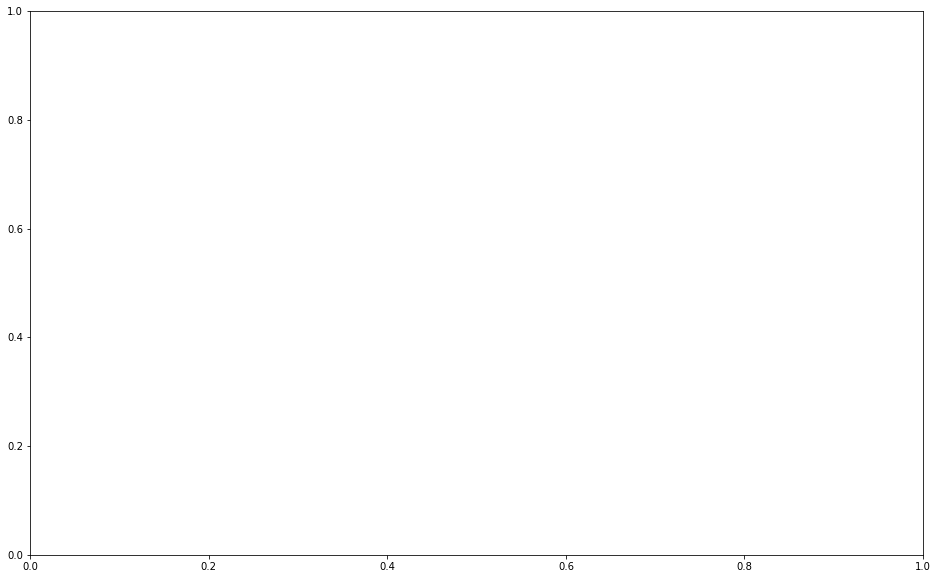

In [12]:
# fig,ax = plt.subplots(figsize=(16,10))

# ax.scatter(x=X_scaled[:,0],y=X_scaled[:,1],c=y_preds,label=y_preds)